In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import tqdm

In [2]:
os.chdir('data')
os.getcwd()

'/Users/samuelchazy/ML_files_X/Applied_Projects/Competitions/Kaggle/Micro_Business_Density/data'

In [3]:
train_df = pd.read_csv('train.csv')
train_df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


In [4]:
#!pip3 install ydata_profiling

In [13]:
from ydata_profiling import ProfileReport
profile = ProfileReport(train_df, title="Profiling Report")

In [12]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/samuelchazy/ML_files_X/Applied_Projects/Competitions/Kaggle/Predict_Future_Sales/venv/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Drop active as it will not be provided in the test data

In [4]:
train_df = train_df.drop(['active','county','state'],axis=1)

### microbusiness density has a 2 year lag (2021 density figures are calculated using 2019 population figures)
1. cfips => A unique identifier for each county. The first two digits correspond to the state FIPS code, while the following 3 represent the county
2. df['column_lag'] = df['column'].shift(periods=2)

In [5]:
train_df['first_day_of_month'] = pd.to_datetime(train_df['first_day_of_month'])
train_df['year'] = train_df['first_day_of_month'].dt.year
train_df['month'] = train_df['first_day_of_month'].dt.month
train_df['year'] = train_df['year'].replace({2019:2017,2020:2018,2021:2019,2022:2020})
train_df = train_df.drop(['year','month'],axis=1)

train_df

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2019-08-01,1001,2019-08-01,3.007682
1,1001_2019-09-01,1001,2019-09-01,2.884870
2,1001_2019-10-01,1001,2019-10-01,3.055843
3,1001_2019-11-01,1001,2019-11-01,2.993233
4,1001_2019-12-01,1001,2019-12-01,2.993233
...,...,...,...,...
122260,56045_2022-06-01,56045,2022-06-01,1.803249
122261,56045_2022-07-01,56045,2022-07-01,1.803249
122262,56045_2022-08-01,56045,2022-08-01,1.785395
122263,56045_2022-09-01,56045,2022-09-01,1.785395


# Census Data

### census data has a 2 year lag

1. pct_bb_[year] => The percentage of households in the county with access to broadband of any type.
2. pct_college_[year] => The percent of the population in the county over age 25 with a 4-year college degree.
3. pct_foreign_born_[year] => The percent of the population in the county born outside the United States.
4. pct_it_workers_[year] => The percent of the workforce in the county employed in information related industries.
5. median_hh_inc_[year] => The median household income in the county.

In [6]:
census_starter = pd.read_csv('census_starter.csv')
census_starter

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,82.2,82.4,84.0,86.7,88.4,56037,15.3,15.2,14.8,13.7,...,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0
3138,83.5,85.9,87.1,89.1,90.5,56039,37.7,37.8,38.9,37.2,...,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0
3139,83.8,88.2,89.5,91.4,90.6,56041,11.9,10.5,11.1,12.6,...,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0
3140,76.4,78.3,78.2,82.8,85.4,56043,15.4,15.0,15.4,15.0,...,1.3,1.0,0.9,0.9,1.1,51362,53426.0,54158,57306.0,62271.0


In [7]:
train_df = pd.merge(train_df,census_starter,on='cfips',how='inner')
train_df

,row_id,cfips,first_day_of_month,microbusiness_density,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001_2019-08-01,1001,2019-08-01,3.007682,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,1001_2019-09-01,1001,2019-09-01,2.884870,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
2,1001_2019-10-01,1001,2019-10-01,3.055843,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
3,1001_2019-11-01,1001,2019-11-01,2.993233,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
4,1001_2019-12-01,1001,2019-12-01,2.993233,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,2022-06-01,1.803249,71.1,73.3,76.8,79.7,81.3,14.1,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
122261,56045_2022-07-01,56045,2022-07-01,1.803249,71.1,73.3,76.8,79.7,81.3,14.1,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
122262,56045_2022-08-01,56045,2022-08-01,1.785395,71.1,73.3,76.8,79.7,81.3,14.1,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
122263,56045_2022-09-01,56045,2022-09-01,1.785395,71.1,73.3,76.8,79.7,81.3,14.1,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0


In [8]:
test_df = pd.read_csv('test.csv')
test_df = pd.merge(test_df,census_starter,on='cfips',how='inner')

test_df

,row_id,cfips,first_day_of_month,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001_2022-11-01,1001,2022-11-01,76.6,78.9,80.6,82.7,85.5,14.5,15.9,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,1001_2022-12-01,1001,2022-12-01,76.6,78.9,80.6,82.7,85.5,14.5,15.9,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
2,1001_2023-01-01,1001,2023-01-01,76.6,78.9,80.6,82.7,85.5,14.5,15.9,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
3,1001_2023-02-01,1001,2023-02-01,76.6,78.9,80.6,82.7,85.5,14.5,15.9,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
4,1001_2023-03-01,1001,2023-03-01,76.6,78.9,80.6,82.7,85.5,14.5,15.9,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25075,56045_2023-02-01,56045,2023-02-01,71.1,73.3,76.8,79.7,81.3,14.1,13.5,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
25076,56045_2023-03-01,56045,2023-03-01,71.1,73.3,76.8,79.7,81.3,14.1,13.5,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
25077,56045_2023-04-01,56045,2023-04-01,71.1,73.3,76.8,79.7,81.3,14.1,13.5,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
25078,56045_2023-05-01,56045,2023-05-01,71.1,73.3,76.8,79.7,81.3,14.1,13.5,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0


# Check missing data and info of Train data

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122265 entries, 0 to 122264
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   first_day_of_month     122265 non-null  datetime64[ns]
 3   microbusiness_density  122265 non-null  float64       
 4   pct_bb_2017            122265 non-null  float64       
 5   pct_bb_2018            122265 non-null  float64       
 6   pct_bb_2019            122265 non-null  float64       
 7   pct_bb_2020            122265 non-null  float64       
 8   pct_bb_2021            122265 non-null  float64       
 9   pct_college_2017       122265 non-null  float64       
 10  pct_college_2018       122265 non-null  float64       
 11  pct_college_2019       122265 non-null  float64       
 12  pct_college_2020       122265 non-null  floa

In [10]:
train_df.describe()

,cfips,microbusiness_density,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
count,122265.000000,122265.000000,122265.000000,122265.000000,122265.000000,122265.000000,122265.000000,122265.000000,122265.000000,122265.000000,...,122265.000000,122226.000000,122265.000000,122265.000000,122265.000000,122265.000000,122226.000000,122265.000000,122226.000000,122226.000000
mean,30376.037640,3.817671,69.938724,72.707209,75.415981,78.559649,80.549729,13.817863,14.010877,14.247656,...,1.425933,1.381876,1.338341,1.310526,1.274354,49765.925359,51602.133376,53497.915152,55043.390236,58257.334716
std,15143.508721,4.991087,9.692780,9.248368,8.832590,8.239703,7.882099,5.582086,5.628779,5.688362,...,0.986235,0.941972,0.938483,0.990387,0.968480,13131.901157,13687.195242,14179.270474,14641.440770,15531.473714
min,1001.000000,0.000000,24.500000,25.700000,34.800000,33.300000,37.000000,2.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,19264.000000,20188.000000,21504.000000,22292.000000,17109.000000
25%,18177.000000,1.639344,64.200000,67.500000,70.500000,74.100000,76.400000,9.700000,9.900000,10.100000,...,0.800000,0.800000,0.700000,0.700000,0.600000,41134.000000,42491.000000,44185.000000,45689.000000,48237.000000
50%,29173.000000,2.586543,70.800000,73.600000,76.500000,79.700000,81.700000,12.800000,13.000000,13.300000,...,1.300000,1.300000,1.200000,1.200000,1.100000,48073.000000,49891.000000,51790.000000,52861.500000,55923.000000
75%,45077.000000,4.519231,76.400000,78.800000,81.400000,84.100000,85.900000,16.800000,17.100000,17.300000,...,1.900000,1.800000,1.800000,1.800000,1.700000,55764.000000,57616.000000,59931.000000,61505.000000,64949.000000
max,56045.000000,284.340030,94.600000,95.500000,96.000000,97.100000,97.600000,43.700000,48.000000,45.400000,...,17.400000,11.700000,10.500000,15.200000,15.200000,129588.000000,136268.000000,142299.000000,147111.000000,156821.000000


In [11]:
train_df.isna().sum()

row_id                    0
cfips                     0
first_day_of_month        0
microbusiness_density     0
pct_bb_2017               0
pct_bb_2018               0
pct_bb_2019               0
pct_bb_2020               0
pct_bb_2021               0
pct_college_2017          0
pct_college_2018          0
pct_college_2019          0
pct_college_2020          0
pct_college_2021          0
pct_foreign_born_2017     0
pct_foreign_born_2018     0
pct_foreign_born_2019     0
pct_foreign_born_2020     0
pct_foreign_born_2021     0
pct_it_workers_2017       0
pct_it_workers_2018      39
pct_it_workers_2019       0
pct_it_workers_2020       0
pct_it_workers_2021       0
median_hh_inc_2017        0
median_hh_inc_2018       39
median_hh_inc_2019        0
median_hh_inc_2020       39
median_hh_inc_2021       39
dtype: int64

In [12]:
train_df.duplicated().sum()

0

# Split Train data into X,y & train and validation data

In [13]:
X = train_df.drop('microbusiness_density',axis=1)
y = train_df['microbusiness_density']

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,shuffle=True)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

In [15]:
X_train

,row_id,cfips,first_day_of_month,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,54011_2022-01-01,54011,2022-01-01,67.5,69.6,71.4,74.3,75.4,14.0,14.6,...,1.8,2.1,2.0,2.4,2.4,37816,38321.0,40028,41472.0,43779.0
1,16065_2019-08-01,16065,2019-08-01,75.9,75.8,76.0,75.6,80.5,25.0,24.5,...,1.4,1.4,1.5,1.2,1.3,33620,36031.0,39160,44419.0,53498.0
2,37047_2020-02-01,37047,2020-02-01,57.6,61.5,66.6,71.4,75.3,8.5,9.0,...,1.0,0.8,1.3,1.4,2.3,36261,36398.0,37628,38487.0,40562.0
3,48261_2021-05-01,48261,2021-05-01,36.2,45.0,48.2,50.4,52.1,3.2,3.1,...,0.0,0.0,0.0,0.0,0.0,24800,36125.0,38021,40083.0,42778.0
4,29171_2019-10-01,29171,2019-10-01,63.0,62.3,65.0,66.1,65.3,12.6,12.5,...,0.6,0.5,0.5,0.8,1.4,37028,37367.0,42849,48833.0,46161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97807,28017_2022-09-01,28017,2022-09-01,51.4,55.3,61.1,61.6,65.3,8.9,9.3,...,0.2,0.4,0.3,0.7,0.8,33579,35939.0,36548,35592.0,38620.0
97808,48179_2020-09-01,48179,2020-09-01,67.3,72.1,73.1,76.8,79.5,9.9,10.2,...,1.8,1.0,1.0,0.9,0.6,48314,47170.0,47952,54679.0,50635.0
97809,20191_2020-01-01,20191,2020-01-01,70.5,73.8,78.8,82.0,82.0,15.6,16.6,...,1.6,2.1,1.7,2.5,2.3,52695,54915.0,55000,53578.0,54854.0
97810,6041_2021-02-01,6041,2021-02-01,88.9,90.5,91.3,93.1,93.7,32.5,33.2,...,5.2,4.8,4.5,4.9,5.1,104703,110217.0,115246,121671.0,131008.0


In [16]:
y_train

0         2.922750
1         5.433808
2         1.296641
3         1.250000
4         1.460048
           ...    
97807     1.231393
97808     5.461014
97809     5.876295
97810    19.199266
97811     3.311560
Name: microbusiness_density, Length: 97812, dtype: float64

# Check the distribution of variables

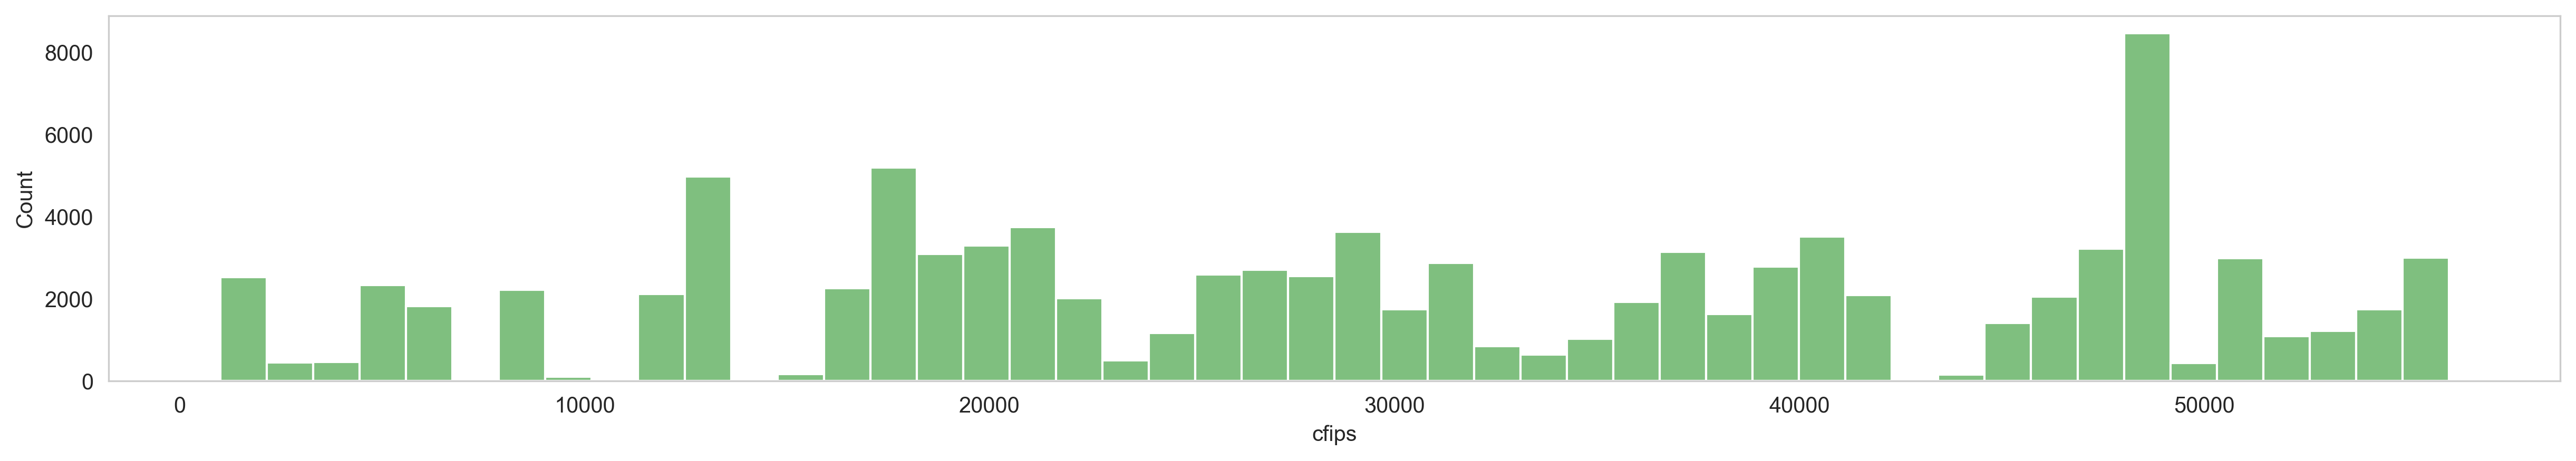

In [17]:
fig,ax = plt.subplots(figsize=(20,3),dpi=300)
year = pd.to_datetime(X_train['first_day_of_month']).dt.year
ax = sns.histplot(data=X_train,x='cfips',color='green',alpha=0.5)
plt.grid(False);

# Target variable

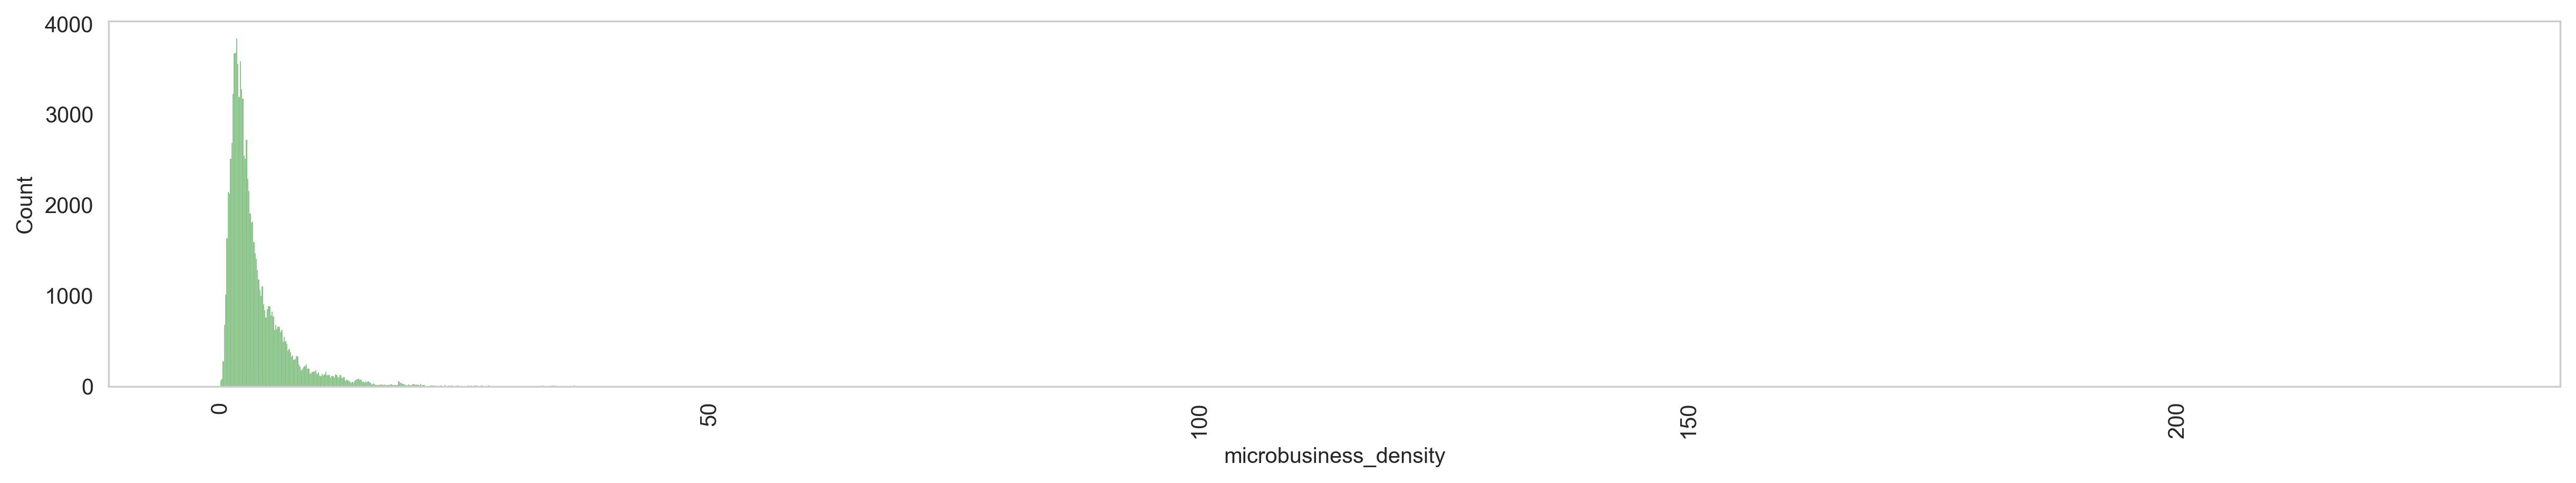

In [18]:
fig,ax = plt.subplots(figsize=(20,3),dpi=300)
ax = sns.histplot(data=y_train,color='green',alpha=0.5)
plt.xticks(rotation=90)
plt.grid(False);

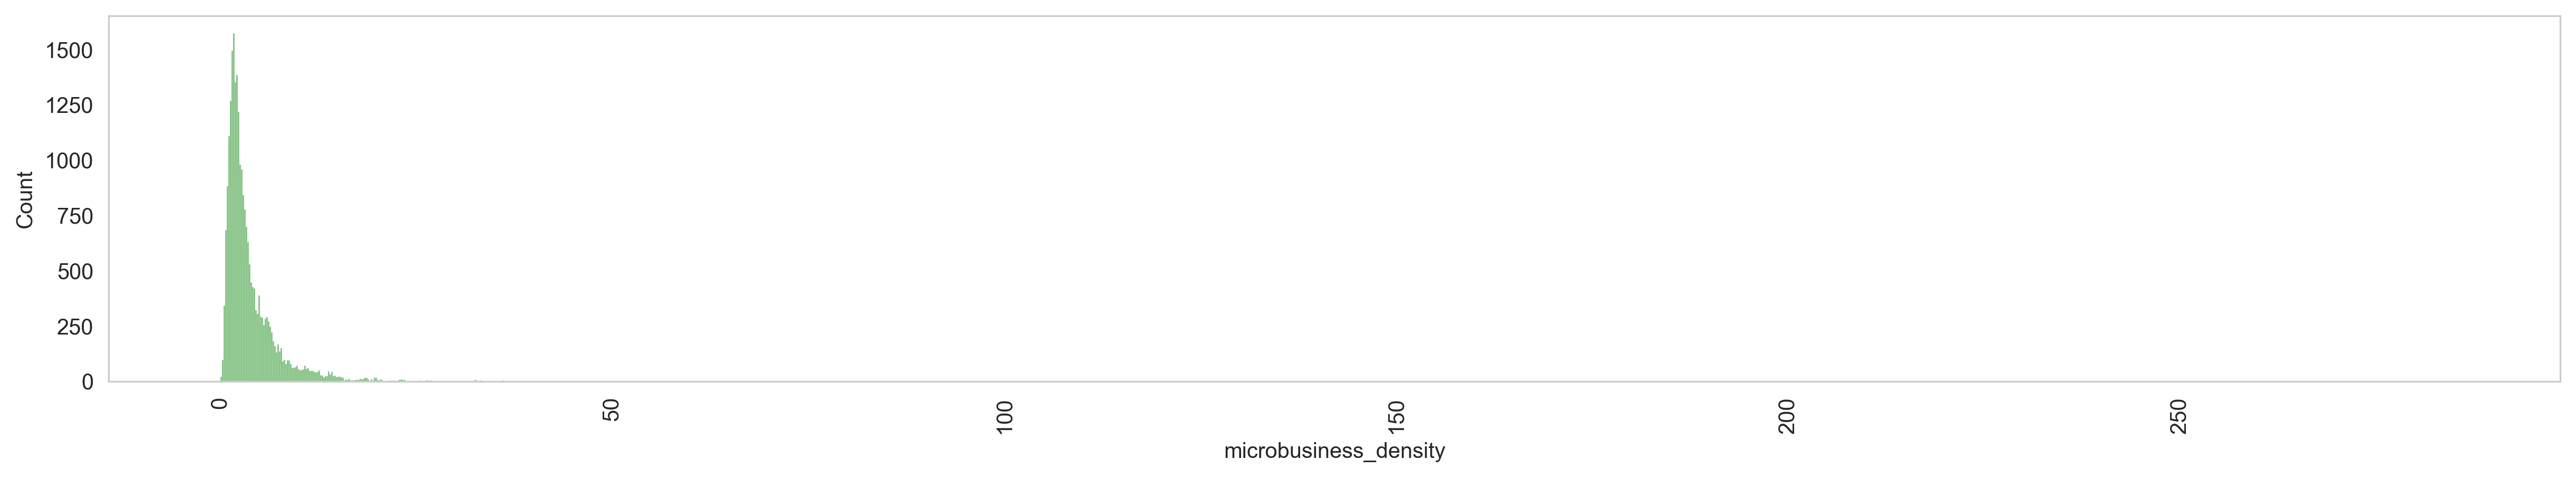

In [19]:
fig,ax = plt.subplots(figsize=(20,3),dpi=300)
ax = sns.histplot(data=y_valid,color='green',alpha=0.5)
plt.xticks(rotation=90)
plt.grid(False);

### Remove outliers

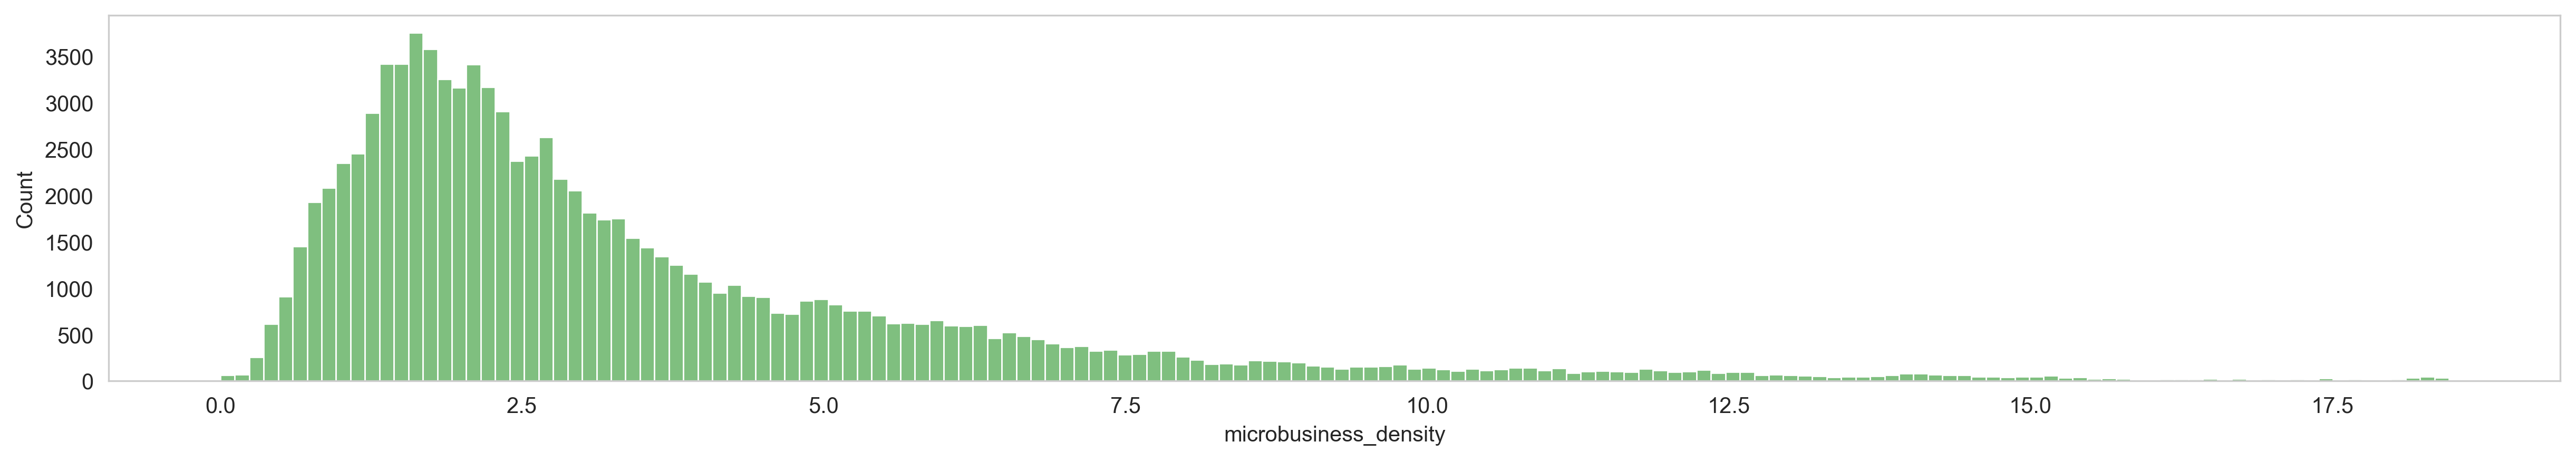

In [20]:
y_train_norm = pd.DataFrame(y_train)
y_train_norm['row_id'] = X_train['row_id']

lower_bound = y_train_norm['microbusiness_density'].mean() - 3*y_train_norm['microbusiness_density'].std()
higher_bound = y_train_norm['microbusiness_density'].mean() + 3*y_train_norm['microbusiness_density'].std()
y_train_norm = y_train_norm[(y_train_norm['microbusiness_density'] > lower_bound) & (y_train_norm['microbusiness_density'] < higher_bound)]

X_train_norm = X_train[X_train['row_id'].isin(y_train_norm['row_id'])].reset_index(drop=True)
y_train_norm = y_train_norm.drop('row_id',axis=1).reset_index(drop=True)

fig,ax = plt.subplots(figsize=(20,3),dpi=300)
ax = sns.histplot(data=y_train_norm['microbusiness_density'],color='green',alpha=0.5)
plt.xticks(rotation=0)
plt.grid(False);

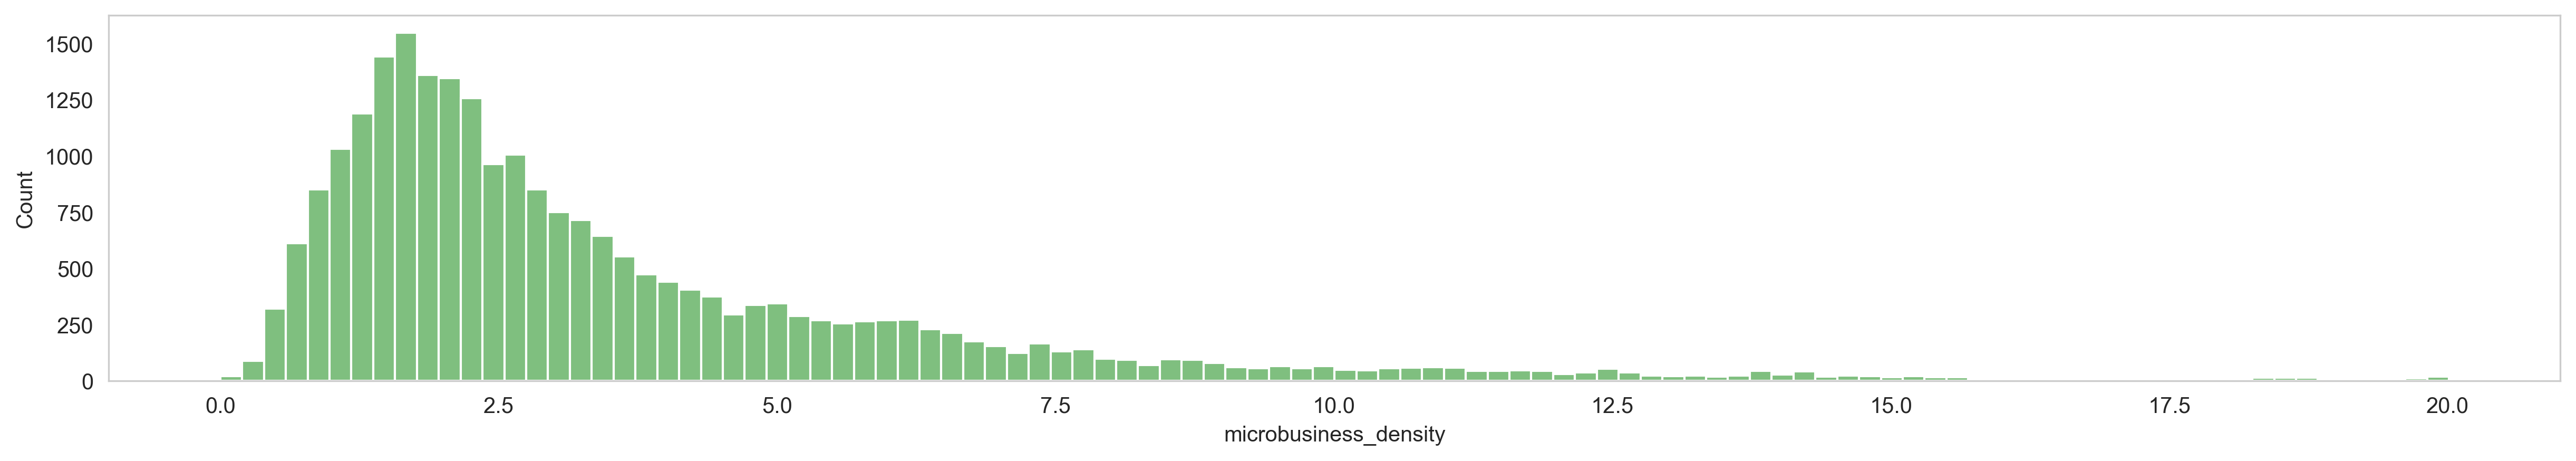

In [21]:
y_valid_norm = pd.DataFrame(y_valid)
y_valid_norm['row_id'] = X_valid['row_id']

lower_bound = y_valid_norm['microbusiness_density'].mean() - 3*y_valid_norm['microbusiness_density'].std()
higher_bound = y_valid_norm['microbusiness_density'].mean() + 3*y_valid_norm['microbusiness_density'].std()
y_valid_norm = y_valid_norm[(y_valid_norm['microbusiness_density'] > lower_bound) & (y_valid_norm['microbusiness_density'] < higher_bound)]

X_valid_norm = X_valid[X_valid['row_id'].isin(y_valid_norm['row_id'])].reset_index(drop=True)
y_valid_norm = y_valid_norm.drop('row_id',axis=1).reset_index(drop=True)

fig,ax = plt.subplots(figsize=(20,3),dpi=300)
ax = sns.histplot(data=y_valid_norm['microbusiness_density'],color='green',alpha=0.5)
plt.xticks(rotation=0)
plt.grid(False);

# Transformations

In [22]:
from sklearn.cluster import KMeans

def transform_data(X_train_df,y_train_y,X_valid_df,y_valid_y,test_df_df):

    ################################################ X_train ################################################
    X_train_df['county'] = [str(n)[-2:] for n in X_train_df['cfips']]
    X_train_df['state'] = [str(n)[:-2] for n in X_train_df['cfips']]
    X_train_df['county'] = pd.to_numeric(X_train_df['county'])
    X_train_df['state'] = pd.to_numeric(X_train_df['state'])

    X_train_df['first_day_of_month'] = pd.to_datetime(X_train_df['first_day_of_month'])
    X_train_df['year'] = X_train_df['first_day_of_month'].dt.year
    X_train_df['month'] = X_train_df['first_day_of_month'].dt.month
    X_train_df = X_train_df.drop('first_day_of_month',axis=1)
    X_train_df = X_train_df.drop(['row_id','cfips'],axis=1)

    X_train_df['weight'] = X_train_df['year'].copy()
    X_train_df['weight'] = X_train_df['weight'].replace({2019:2,2020:4,2021:6,2022:8,2023:10})

    X_train_df = X_train_df.fillna(X_train_df.mean())

    ################################################ X_valid ################################################
    X_valid_df['county'] = [str(n)[-2:] for n in X_valid_df['cfips']]
    X_valid_df['state'] = [str(n)[:-2] for n in X_valid_df['cfips']]
    X_valid_df['county'] = pd.to_numeric(X_valid_df['county'])
    X_valid_df['state'] = pd.to_numeric(X_valid_df['state'])

    X_valid_df['first_day_of_month'] = pd.to_datetime(X_valid_df['first_day_of_month'])
    X_valid_df['year'] = X_valid_df['first_day_of_month'].dt.year
    X_valid_df['month'] = X_valid_df['first_day_of_month'].dt.month
    X_valid_df = X_valid_df.drop('first_day_of_month',axis=1)
    X_valid_df = X_valid_df.drop(['row_id','cfips'],axis=1)

    X_valid_df['weight'] = X_valid_df['year'].copy()
    X_valid_df['weight'] = X_valid_df['weight'].replace({2019:2,2020:4,2021:6,2022:8,2023:10})

    X_valid_df = X_valid_df.fillna(X_valid_df.mean())

    ################################################ test_df ################################################
    test_df_df['county'] = [str(n)[-2:] for n in test_df_df['cfips']]
    test_df_df['state'] = [str(n)[:-2] for n in test_df_df['cfips']]
    test_df_df['county'] = pd.to_numeric(test_df_df['county'])
    test_df_df['state'] = pd.to_numeric(test_df_df['state'])

    test_df_df['first_day_of_month'] = pd.to_datetime(test_df_df['first_day_of_month'])
    test_df_df['year'] = test_df_df['first_day_of_month'].dt.year
    test_df_df['month'] = test_df_df['first_day_of_month'].dt.month
    test_df_df = test_df_df.drop('first_day_of_month',axis=1)
    test_df_df = test_df_df.drop(['row_id','cfips'],axis=1)

    test_df_df['weight'] = test_df_df['year'].copy()
    test_df_df['weight'] = test_df_df['weight'].replace({2019:2,2020:4,2021:6,2022:8,2023:10})

    test_df_df = test_df_df.fillna(test_df_df.mean())

    ################################################ Clustering ################################################

    Total_df = pd.concat([X_train_df,X_valid_df],axis=0)

    kmeans = KMeans(n_clusters=6)
    kmeans.fit(Total_df)
    labels = kmeans.labels_
    Total_df['cluster'] = labels

    X_train_df['cluster'] = kmeans.predict(X_train_df)
    X_valid_df['cluster'] = kmeans.predict(X_valid_df)
    test_df_df['cluster'] = kmeans.predict(test_df_df)

    ################################################ Output ################################################

    return X_train_df,X_valid_df,test_df_df

In [23]:
X_train_transformed,X_valid_transformed,test_df_transformed = transform_data(X_train_norm,y_train_norm,X_valid_norm,y_valid_norm,test_df)

/Users/samuelchazy/ML_files_X/Applied_Projects/Competitions/Kaggle/Predict_Future_Sales/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
X_train_transformed

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,...,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,county,state,year,month,weight,cluster
0,67.5,69.6,71.4,74.3,75.4,14.0,14.6,15.1,15.3,16.3,...,38321.0,40028,41472.0,43779.0,11,540,2022,1,8,3
1,75.9,75.8,76.0,75.6,80.5,25.0,24.5,25.1,27.7,26.6,...,36031.0,39160,44419.0,53498.0,65,160,2019,8,2,0
2,57.6,61.5,66.6,71.4,75.3,8.5,9.0,9.2,8.7,9.5,...,36398.0,37628,38487.0,40562.0,47,370,2020,2,4,3
3,36.2,45.0,48.2,50.4,52.1,3.2,3.1,0.3,0.4,1.9,...,36125.0,38021,40083.0,42778.0,61,482,2021,5,6,3
4,63.0,62.3,65.0,66.1,65.3,12.6,12.5,11.7,12.1,11.5,...,37367.0,42849,48833.0,46161.0,71,291,2019,10,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96755,76.9,79.0,80.1,83.7,85.4,9.6,10.0,10.2,10.2,12.1,...,59574.0,63892,61889.0,69632.0,73,180,2019,11,2,2
96756,51.4,55.3,61.1,61.6,65.3,8.9,9.3,9.9,9.8,9.4,...,35939.0,36548,35592.0,38620.0,17,280,2022,9,8,3
96757,67.3,72.1,73.1,76.8,79.5,9.9,10.2,9.5,10.6,11.0,...,47170.0,47952,54679.0,50635.0,79,481,2020,9,4,0
96758,70.5,73.8,78.8,82.0,82.0,15.6,16.6,16.9,17.6,18.2,...,54915.0,55000,53578.0,54854.0,91,201,2020,1,4,4


In [25]:
test_df_transformed

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,...,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,county,state,year,month,weight,cluster
0,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,58786.0,58731,57982.0,62660.0,1,10,2022,11,8,4
1,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,58786.0,58731,57982.0,62660.0,1,10,2022,12,8,4
2,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,58786.0,58731,57982.0,62660.0,1,10,2023,1,10,4
3,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,58786.0,58731,57982.0,62660.0,1,10,2023,2,10,4
4,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,58786.0,58731,57982.0,62660.0,1,10,2023,3,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25075,71.1,73.3,76.8,79.7,81.3,14.1,13.5,13.4,12.7,13.9,...,52867.0,57031,53333.0,65566.0,45,560,2023,2,10,4
25076,71.1,73.3,76.8,79.7,81.3,14.1,13.5,13.4,12.7,13.9,...,52867.0,57031,53333.0,65566.0,45,560,2023,3,10,4
25077,71.1,73.3,76.8,79.7,81.3,14.1,13.5,13.4,12.7,13.9,...,52867.0,57031,53333.0,65566.0,45,560,2023,4,10,4
25078,71.1,73.3,76.8,79.7,81.3,14.1,13.5,13.4,12.7,13.9,...,52867.0,57031,53333.0,65566.0,45,560,2023,5,10,4


# Check correlations

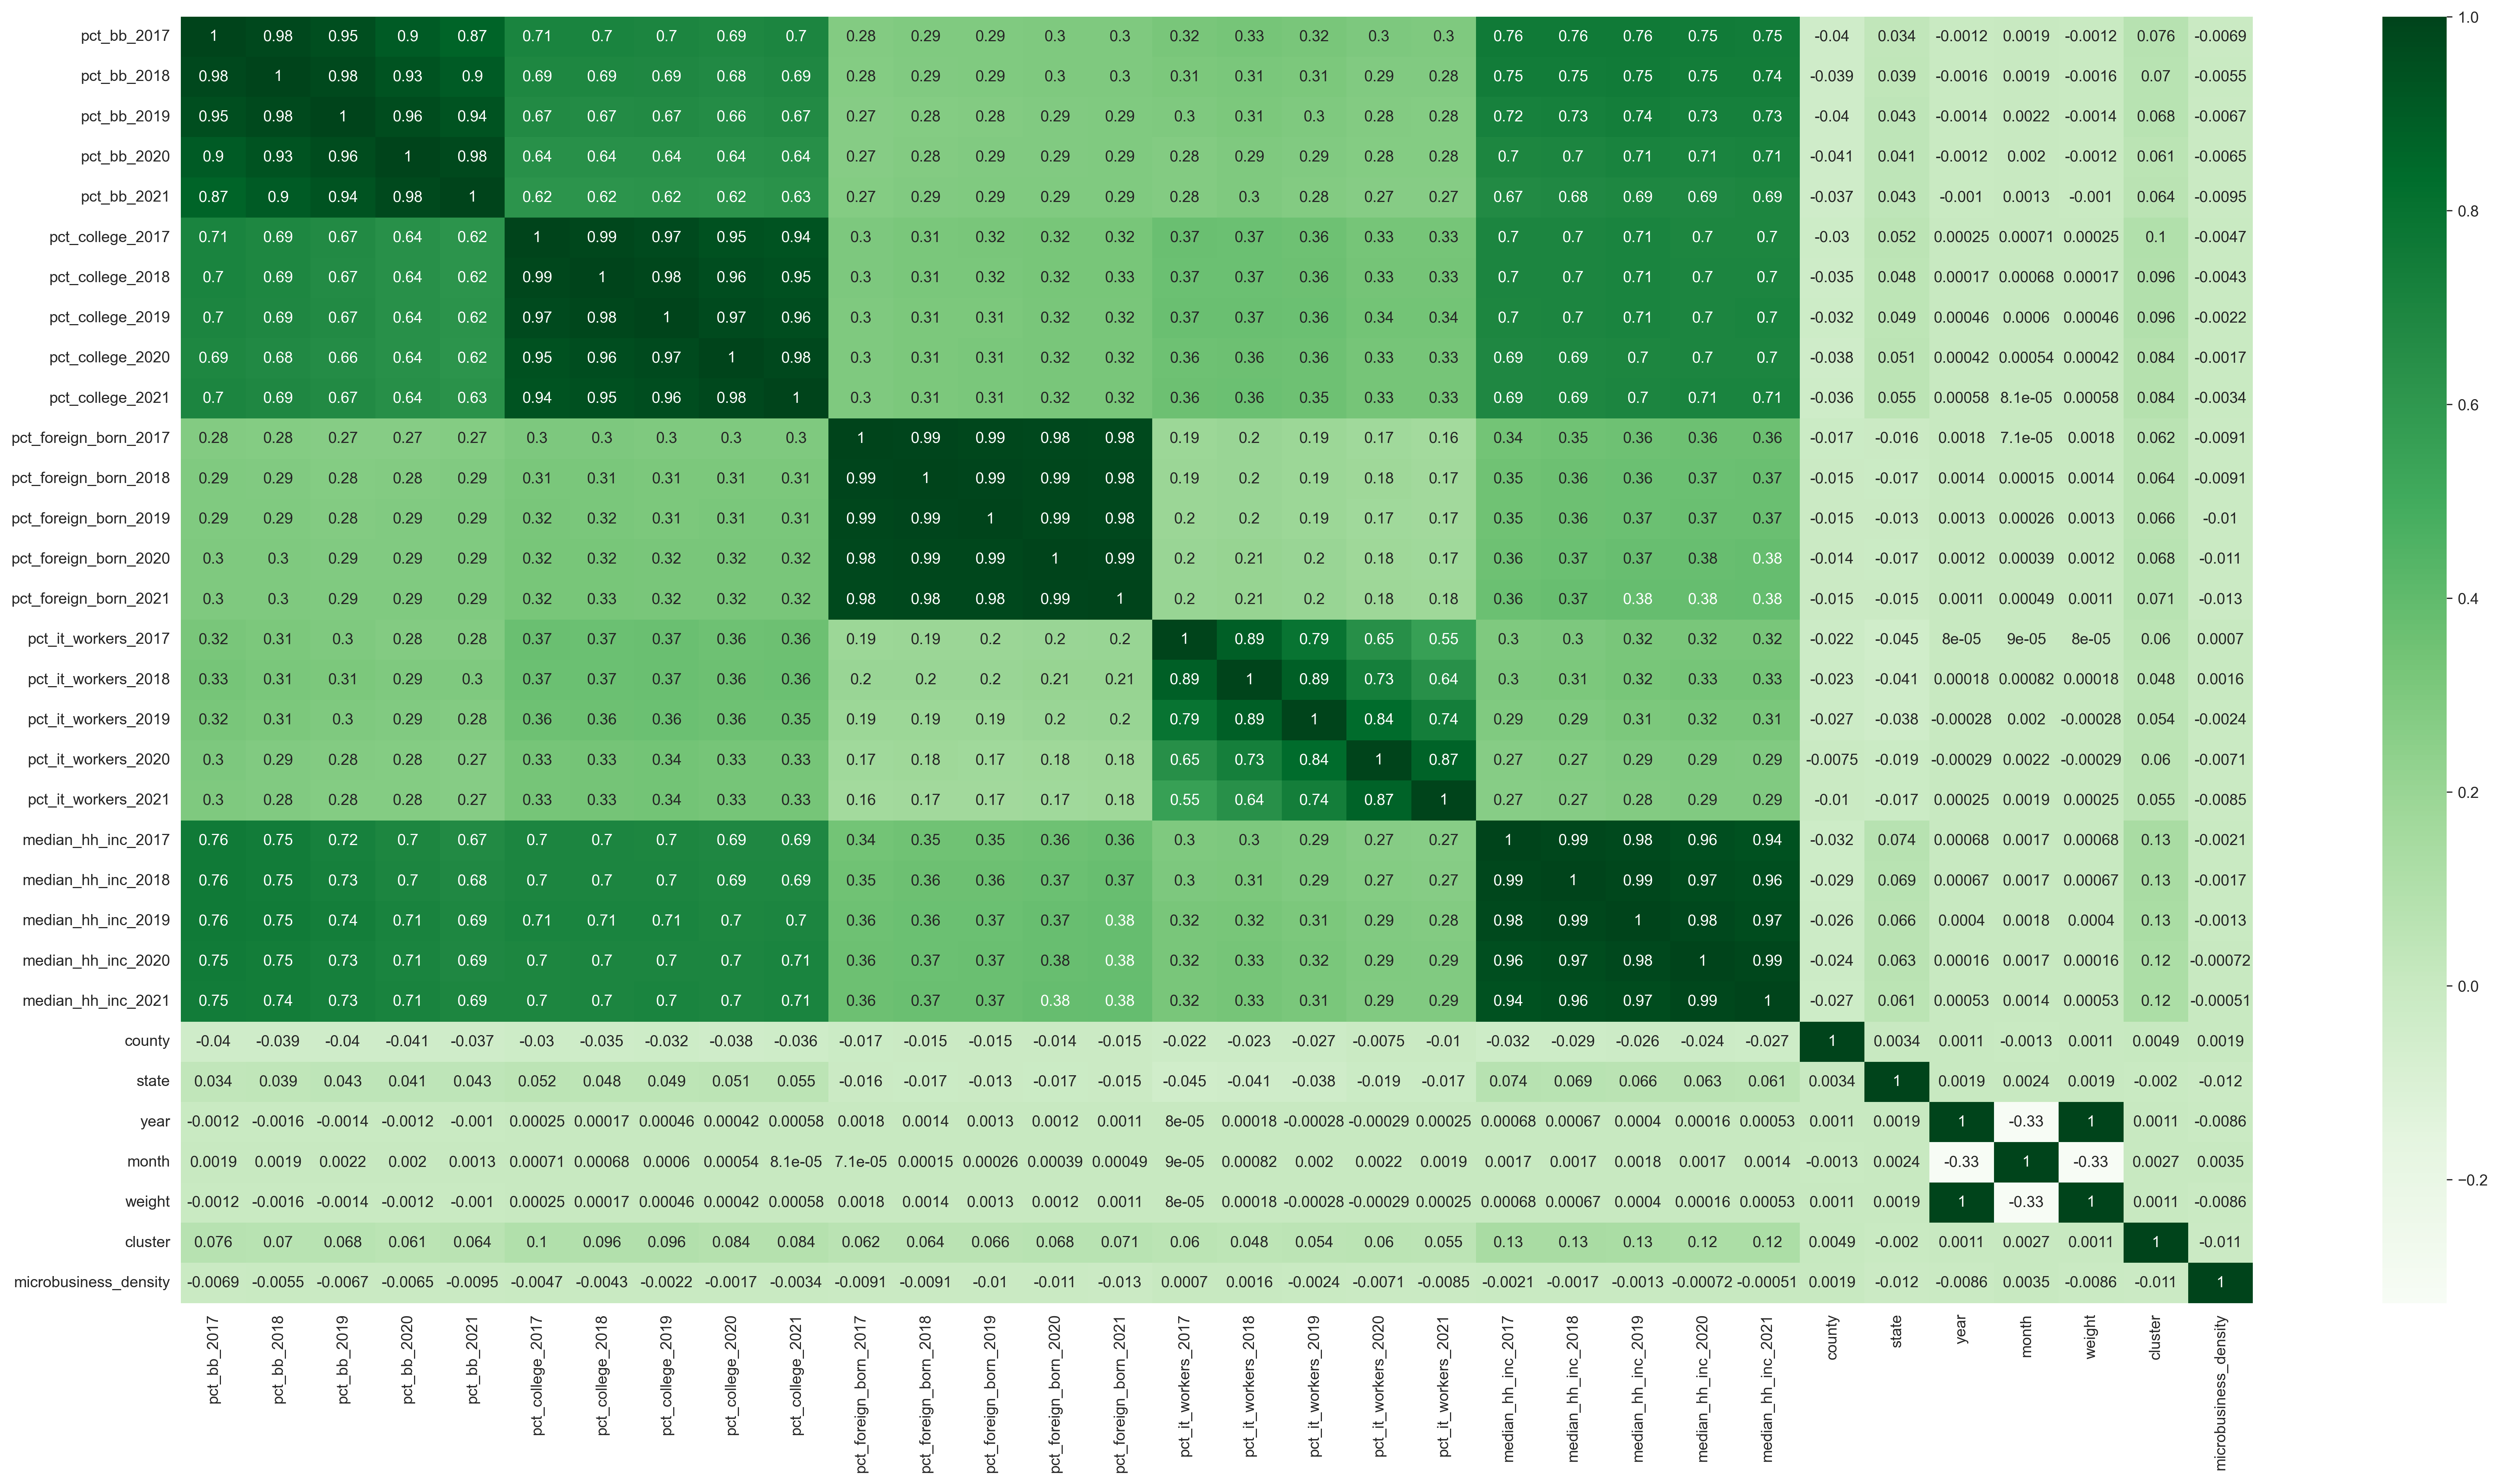

In [26]:
cor = X_train_transformed.copy()
cor = pd.concat([cor,y_valid],axis=1)
cor= cor.corr()

fig,ax = plt.subplots(figsize=(30,15),dpi=300)
ax = sns.heatmap(cor,annot=True,cmap='Greens');

# Check Multicollinearity

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vars = cor.copy()
vars = vars.drop(['microbusiness_density','median_hh_inc_2018','pct_foreign_born_2018','pct_foreign_born_2020','pct_college_2018','pct_bb_2018','median_hh_inc_2020','pct_foreign_born_2019',
                  'median_hh_inc_2019','pct_college_2020','pct_bb_2020','pct_college_2019','pct_bb_2019','pct_foreign_born_2021','median_hh_inc_2021','pct_college_2017',
                  'pct_it_workers_2018','pct_bb_2017','pct_it_workers_2020','pct_it_workers_2019','median_hh_inc_2017','pct_college_2021','pct_it_workers_2017'],axis=1)

vif = pd.DataFrame()
vif['features'] = vars.columns
vif['vif_Factor'] = [variance_inflation_factor(vars.values, i) for i in range(vars.shape[1])]
vif.loc[vif['vif_Factor'] < 5, 'vif_Factor_Description'] = 'standard'
vif.loc[(vif['vif_Factor'] >= 5) & (vif['vif_Factor'] < 10), 'vif_Factor_Description'] = 'Concerning'
vif.loc[vif['vif_Factor'] >= 10, 'vif_Factor_Description'] = 'Problematic'

vif[vif['vif_Factor_Description'].isna() == False]

/Users/samuelchazy/ML_files_X/Applied_Projects/Competitions/Kaggle/Predict_Future_Sales/venv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,vif_Factor,vif_Factor_Description
0,pct_bb_2021,1.395500,standard
1,pct_foreign_born_2017,0.842410,standard
2,pct_it_workers_2021,0.914578,standard
3,county,1.100276,standard
4,state,0.976813,standard
5,year,inf,Problematic
6,month,1.820321,standard
7,weight,inf,Problematic
8,cluster,1.475240,standard


# Final Data

In [28]:
X_train_transformed_final = X_train_transformed.fillna(X_train_transformed.mean())
X_valid_transformed_final = X_valid_transformed.fillna(X_valid_transformed.mean())
test_df_transformed_final = test_df_transformed.fillna(X_valid_transformed.mean())

# Normalize the data

In [31]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

X_train_transformed_final = pd.DataFrame(scaler.fit_transform(X_train_transformed_final))
X_valid_transformed_final = pd.DataFrame(scaler.transform(X_valid_transformed_final))
test_df_transformed_final = pd.DataFrame(scaler.transform(test_df_transformed_final))

# pca = PCA(n_components=20)
# X_train_transformed_final = pd.DataFrame(pca.fit_transform(X_train_transformed_final))
# X_valid_transformed_final = pd.DataFrame(pca.transform(X_valid_transformed_final))
# test_df_transformed_final = pd.DataFrame(pca.transform(test_df_transformed_final))

# pd.DataFrame(pca.explained_variance_ratio_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.255759,0.237006,0.115114,0.091263,0.086052,0.082251,0.049594,0.032009,0.018887,0.017856,0.003381,0.002764,0.001948,0.000996,0.000892


In [32]:
X_train_transformed_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.751673,-0.109100,-0.147698,-0.312800,0.260604,-0.483305,-0.066969,0.191738,0.208859,-0.031916,0.038358,-0.038845,0.025241,-0.001912,0.012876
1,0.793270,0.230644,0.462472,0.233089,0.159493,0.288679,-0.137146,0.511858,0.091349,-0.316350,0.054855,0.000297,0.051393,-0.068198,-0.021232
2,0.169278,-0.473862,-0.234172,0.016944,0.496744,-0.183154,0.056325,0.029414,0.080278,-0.003531,-0.056505,-0.072232,-0.020168,0.009364,0.009900
3,-0.193316,-0.959421,-0.352935,0.150107,0.074859,-0.302228,1.060877,0.133270,-0.232291,0.109200,0.034626,-0.004392,-0.031940,-0.078545,-0.020451
4,0.848597,-0.510985,0.341209,0.278482,-0.035103,0.025075,-0.057403,0.196277,-0.104048,0.014267,0.102241,-0.056147,-0.011116,-0.062645,0.013949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96755,0.879773,0.017173,0.011137,0.281472,-0.100384,0.247809,-0.106772,-0.300533,0.032596,0.150957,0.012827,0.028916,0.024926,-0.007380,0.043356
96756,-0.520786,-0.637210,-0.261595,-0.310873,-0.391899,0.012117,0.046959,0.205821,-0.108279,-0.011147,0.006271,-0.036832,-0.006308,0.003421,0.007370
96757,0.373396,-0.219306,0.385508,0.391468,-0.123863,-0.260145,0.297178,-0.125570,0.002120,-0.008609,0.015231,0.032778,0.001945,0.009107,0.010256
96758,0.142191,0.155217,-0.368404,0.455577,0.607904,0.152249,-0.207422,0.075251,0.091874,0.011452,-0.029776,-0.042186,0.010486,0.051063,0.026545


# Build an OLS base regression model

In [33]:
import statsmodels.api as sm

X_OLS = sm.add_constant(X_train_transformed_final)
OLS = sm.OLS(y_train_norm,X_OLS)
model_OLS = OLS.fit()
model_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     microbusiness_density   R-squared:                       0.580
Model:                               OLS   Adj. R-squared:                  0.580
Method:                    Least Squares   F-statistic:                     8895.
Date:                   Thu, 19 Jan 2023   Prob (F-statistic):               0.00
Time:                           13:10:34   Log-Likelihood:            -1.9675e+05
No. Observations:                  96760   AIC:                         3.935e+05
Df Residuals:                      96744   BIC:                         3.937e+05
Df Model:                             15                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4978      0.006    588.506      0.000       3.486       3.509
0             -0.0175      0.012     -1.426      0.154      -0.042       0.007
1              4.3618      0.013    342.446      0.000       4.337       4.387
2              0.8135      0.018     44.511      0.000       0.778       0.849
3             -0.0752      0.021     -3.664      0.000      -0.115      -0.035
4             -0.0122      0.021     -0.578      0.563      -0.054       0.029
5              0.9266      0.022     42.856      0.000       0.884       0.969
6              1.0464      0.028     37.579      0.000       0.992       1.101
7              2.9961      0.035     86.443      0.000       2.928       3.064
8              1.5226      0.045     33.745      0.000       1.434       1.611
9             -0.6177      0.046    -13.310      0.000      -0.709      -0.527
10            -0.0945      0.107     -0.886      0.376      -0.303       0.115
11             0.1318      0.118      1.117      0.264      -0.099       0.363
12             1.6654      0.140     11.854      0.000       1.390       1.941
13            -8.3577      0.197    -42.526      0.000      -8.743      -7.973
14             2.6758      0.208     12.886      0.000       2.269       3.083
==============================================================================
Omnibus:                    36410.792   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           283349.069
Skew:                           1.609   Prob(JB):                         0.00
Kurtosis:                      10.741   Cond. No.                         34.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Check Residuals

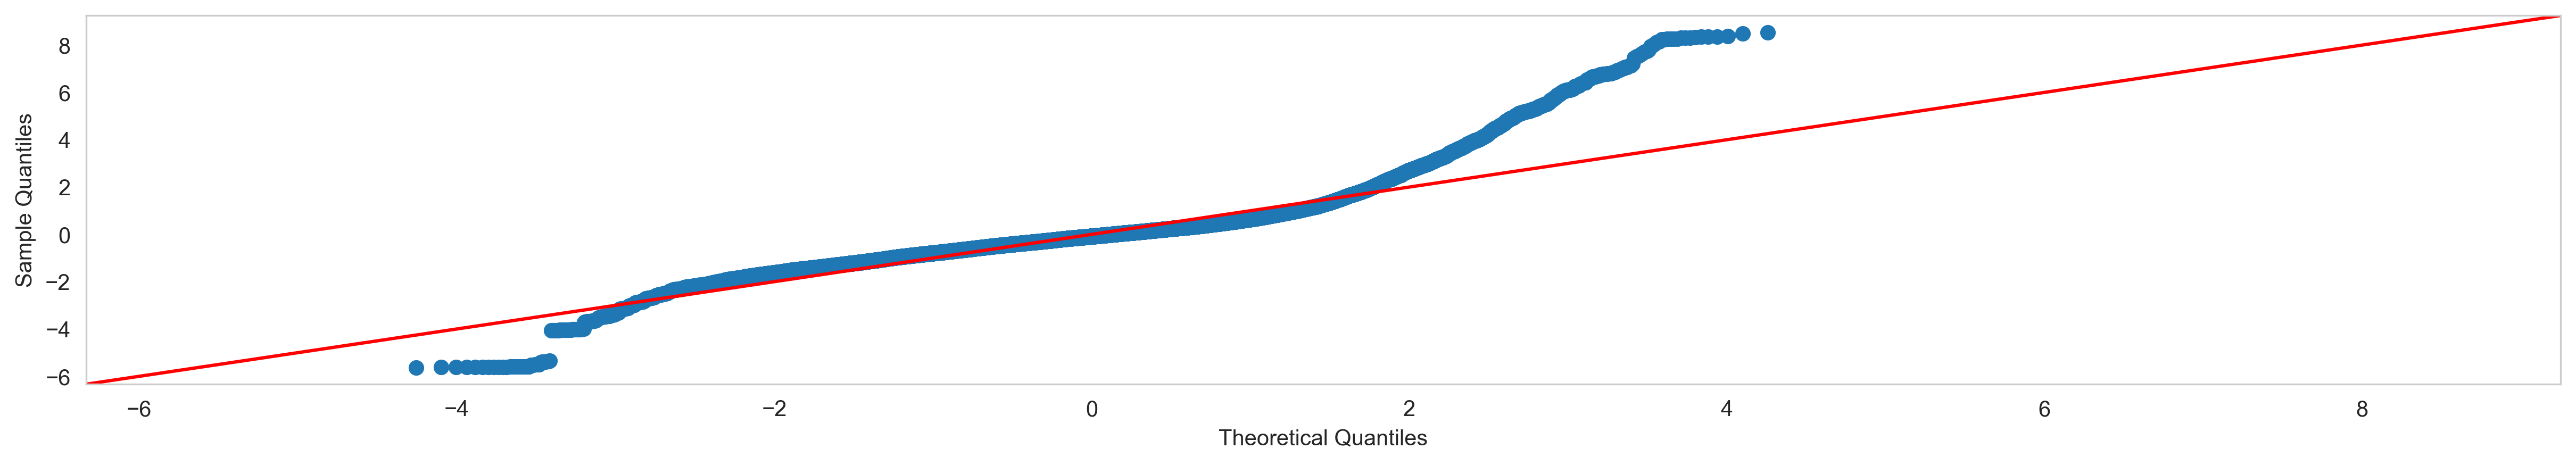

In [34]:
residuals = model_OLS.resid
figure,ax = plt.subplots(figsize=(20,3),dpi=300)
qqplot = sm.qqplot(residuals,line='45',fit=True,ax=ax)
plt.grid(False)

# Check Heteroscedasticity

In [35]:
# from statsmodels.stats.diagnostic import het_white
#
# white_test = het_white(residuals,exog=model_OLS.model.exog)
# labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
# display(dict(zip(labels, white_test)))
# if white_test[1] <= 0.05:
#     print('heteroscedasticity is present in the regression model')
# else:
#     print('heteroscedasticity is not present in the regression model')

In [36]:
#assert model_OLS.df_model == (np.linalg.matrix_rank(model_OLS.model.exog)-1)

# Final Testing metrics

In [37]:
def smape(y_true,y_pred):
    smap = np.zeros(len(y_true))
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]

    return 100 * np.mean(smap)

# Build Random Forest Model

In [55]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from scipy.stats import randint as sp_randint
#
# model_RF = RandomForestRegressor()
# param_dist = {'n_estimators': sp_randint(50, 500), 'max_depth': [5,10,15,20,25,30,35,40,45,50,None],'min_samples_leaf': sp_randint(1,10)}
#
# random_search = RandomizedSearchCV(model_RF,param_distributions=param_dist,n_iter=10,cv=5, scoring='neg_mean_squared_error')
# random_search.fit(X_train_transformed_final,y_train_norm['microbusiness_density'])
#
# print("Best parameters:", random_search.best_params_)
# print("Best score:", random_search.best_score_)

In [39]:
# from sklearn.ensemble import RandomForestRegressor
#
# model_RF = RandomForestRegressor(n_estimators=500,max_depth=50,random_state=42)
# model_RF.fit(X_train_transformed_final,y_train_norm['microbusiness_density'])
#
# y_pred_RF = model_RF.predict(X_valid_transformed_final)

Training score: 0.9990818970709575
Testing score: 0.9789403801935974


In [40]:
# print(f'Training score: {model_RF.score(X_train_transformed_final,y_train_norm)}')
# print(f'Testing score: {model_RF.score(X_valid_transformed_final,y_valid_norm)}')

MAE = 0.088
--------------------------------------------------------------------------------
MSE = 0.194
--------------------------------------------------------------------------------
RMSE = 0.441
--------------------------------------------------------------------------------


In [41]:
# from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
#
# mae = round(mean_absolute_error(y_valid_norm,y_pred_RF),3)
# print(f'MAE = {mae}')
# print('-'*80)
#
# mse = round(mean_squared_error(y_valid_norm,y_pred_RF),3)
# print(f'MSE = {mse}')
# print('-'*80)
#
# rmse = round(np.sqrt(mean_squared_error(y_valid_norm,y_pred_RF)),3)
# print(f'RMSE = {rmse}')
# print('-'*80)
#
# r2score = round(r2_score(y_valid_norm,y_pred_RF),3)
# print(f'r2_score = {r2score}')
# print('-'*80)

2.566064618479372

In [42]:
# smape(y_valid_norm['microbusiness_density'],y_pred_RF)

# Stacking Regressor

In [271]:
# from sklearn.ensemble import GradientBoostingRegressor,ExtraTreesRegressor,RandomForestRegressor
# from sklearn.ensemble import StackingRegressor
# import xgboost as xgb
#
# GB = GradientBoostingRegressor(n_estimators=150,max_depth=75)
# RF = RandomForestRegressor(n_estimators=150,max_depth=75)
# XGB = xgb.XGBRegressor(n_estimators=150,max_depth=75)
#
# stacking_regressor = StackingRegressor(estimators=[('GB', GB),('RF',RF),('XGB',XGB)])
# stacking_regressor.fit(X_train_transformed_final,y_train_norm['microbusiness_density'])
#
# y_pred_sg = stacking_regressor.predict(X_valid_transformed_final)

In [ ]:
# print(f'Training score: {stacking_regressor.score(X_train_transformed_final,y_train_norm)}')
# print(f'Testing score: {stacking_regressor.score(X_valid_transformed_final,y_valid_norm)}')

In [ ]:
# from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
#
# mae = round(mean_absolute_error(y_valid_norm,y_pred_sg),3)
# print(f'MAE = {mae}')
# print('-'*80)
#
# mse = round(mean_squared_error(y_valid_norm,y_pred_sg),3)
# print(f'MSE = {mse}')
# print('-'*80)
#
# rmse = round(np.sqrt(mean_squared_error(y_valid_norm,y_pred_sg)),3)
# print(f'RMSE = {rmse}')
# print('-'*80)
#
# r2score = round(r2_score(y_valid_norm,y_pred_sg),3)
# print(f'r2_score = {r2score}')
# print('-'*80)

In [ ]:
# smape(y_valid_norm['microbusiness_density'],y_pred_sg)

# XGB Regressor

In [43]:
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Define the custom SMAPE scoring function
def smape(y_true, y_pred):
    return 200*np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Create a scorer for SMAPE
smape_scorer = make_scorer(smape, greater_is_better=False)

param_grid = {
    'max_depth': [4, 6, 8, 10],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0, 0.1, 1]}

regressor = xgb.XGBRegressor()

grid_search = GridSearchCV(regressor,param_grid,cv=5,scoring=smape_scorer)
grid_search.fit(X_train_transformed_final,y_train_norm['microbusiness_density'])

print(grid_search.best_params_)

Training score: 0.9999999832385659
Testing score: 0.9775843861299359


In [45]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=1500,max_depth=45,reg_lambda=1e-4)
xgb_model.fit(X_train_transformed_final,y_train_norm['microbusiness_density'])

y_pred_xgb = xgb_model.predict(X_valid_transformed_final)

MAE = 0.082
--------------------------------------------------------------------------------
MSE = 0.207
--------------------------------------------------------------------------------
RMSE = 0.455
--------------------------------------------------------------------------------


In [46]:
print(f'Training score: {xgb_model.score(X_train_transformed_final,y_train_norm)}')
print(f'Testing score: {xgb_model.score(X_valid_transformed_final,y_valid_norm)}')

2.4505154849686805

In [47]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score

mae = round(mean_absolute_error(y_valid_norm,y_pred_xgb),3)
print(f'MAE = {mae}')
print('-'*80)

mse = round(mean_squared_error(y_valid_norm,y_pred_xgb),3)
print(f'MSE = {mse}')
print('-'*80)

rmse = round(np.sqrt(mean_squared_error(y_valid_norm,y_pred_xgb)),3)
print(f'RMSE = {rmse}')
print('-'*80)

r2score = round(r2_score(y_valid_norm,y_pred_xgb),3)
print(f'r2_score = {r2score}')
print('-'*80)

In [48]:
smape(y_valid_norm['microbusiness_density'],y_pred_xgb)

# Build a Neural Network

#### Normalize the data

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
#
# normalizer = MinMaxScaler()
# X_train_transformed_final_norm = normalizer.fit_transform(X_train_transformed_final)
# X_valid_transformed_final_norm = normalizer.transform(X_valid_transformed_final)
# test_df_transformed_final_norm = normalizer.transform(test_df_transformed_final)

In [ ]:
# import tensorflow as tf
#
# tf_model = tf.keras.Sequential()
# tf_model.add(tf.keras.layers.Dense(units=1024,input_shape=[X_train_transformed_final_norm.shape[1]],kernel_regularizer=tf.keras.regularizers.l1_l2(0.1)))
# tf_model.add(tf.keras.layers.Dropout(0.2))
# tf_model.add(tf.keras.layers.Dense(1024,activation='relu'))
# tf_model.add(tf.keras.layers.Dropout(0.2))
# tf_model.add(tf.keras.layers.Dense(1024,activation='relu'))
# tf_model.add(tf.keras.layers.Dropout(0.2))
# tf_model.add(tf.keras.layers.Dense(1024,activation='relu'))
# tf_model.add(tf.keras.layers.Dropout(0.2))
# tf_model.add(tf.keras.layers.Dense(1024,activation='relu'))
# tf_model.add(tf.keras.layers.Dropout(0.2))
#
# tf_model.add(tf.keras.layers.Dense(1))
#
# tf_model.compile(tf.keras.optimizers.Adam(0.00001),loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
#
# print(f'Input shape: {tf_model.input_shape}')
# tf_model.summary()

In [ ]:
# callbacks_list = tf.keras.callbacks.EarlyStopping(monitor="root_mean_squared_error",patience=15)
# history = tf_model.fit(X_train_transformed_final_norm,y_train_norm,epochs=500,callbacks=[callbacks_list],validation_split=0.2)

In [ ]:
# tf_model.evaluate(X_train_transformed_final_norm,y_train_norm)

In [ ]:
# tf_model.evaluate(X_valid_transformed_final_norm,y_valid_norm)

In [ ]:
# tf_pred = tf_model.predict(X_valid_transformed_final_norm)

In [ ]:
# from sklearn.metrics import r2_score,mean_absolute_percentage_error
#
# r2 = r2_score(y_valid_norm,tf_pred)
# rmse = round(np.sqrt(mean_squared_error(y_valid_norm,tf_pred)),3)
#
# print(f'R2_score: {r2}')
# print(f'rmse: {rmse}')

In [ ]:
# history.history.keys()

In [ ]:
# history_dict = history.history
# history_dict.keys() # to get the loss names
# loss_values = history_dict['val_loss']
# acc_values = history_dict['val_root_mean_squared_error']
# epochs = range(1, len(loss_values) + 1)
#
# fig, axes = plt.subplots(2)
# axes[0].set_ylabel("loss", fontsize=14)
# axes[0].plot(loss_values)
# axes[1].set_ylabel("rmse", fontsize=14)
# axes[1].set_xlabel("Iteration", fontsize=14)
# axes[1].plot(acc_values)
# plt.show()

In [62]:
# smape(y_valid_norm['microbusiness_density'],tf_pred.ravel())

# Predict final data

In [64]:
test_df_pred = xgb_model.predict(test_df_transformed_final)

In [65]:
submission = pd.DataFrame(test_df['row_id'])
submission['microbusiness_density'] = test_df_pred

submission

# Save the submission file

In [ ]:
submission.to_csv('submission.csv',index=False)